In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff 
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Loading Data into Pandas

In [2]:
# get arff file
data = arff.loadarff('data/EEG Eye State.arff')
# convert to dataframe
df = pd.DataFrame(data[0])
df.shape

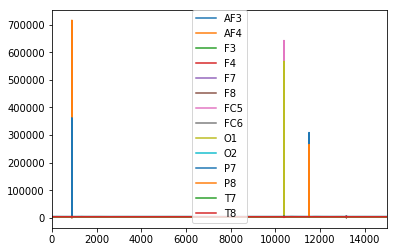

In [6]:
#plot data
df[df.columns.difference(['eyeDetection'])].plot()

In [7]:
# check classes
df.eyeDetection.unique()

array([b'0', b'1'], dtype=object)

In [8]:
# save as normal string
df['eyeDetection'] = df['eyeDetection'].str.decode('utf-8')

In [9]:
# remove outlier
for column in df.columns.difference(['eyeDetection']):
    df = df[((df[column] - df[column].mean()) / df[column].std()).abs() < 20]

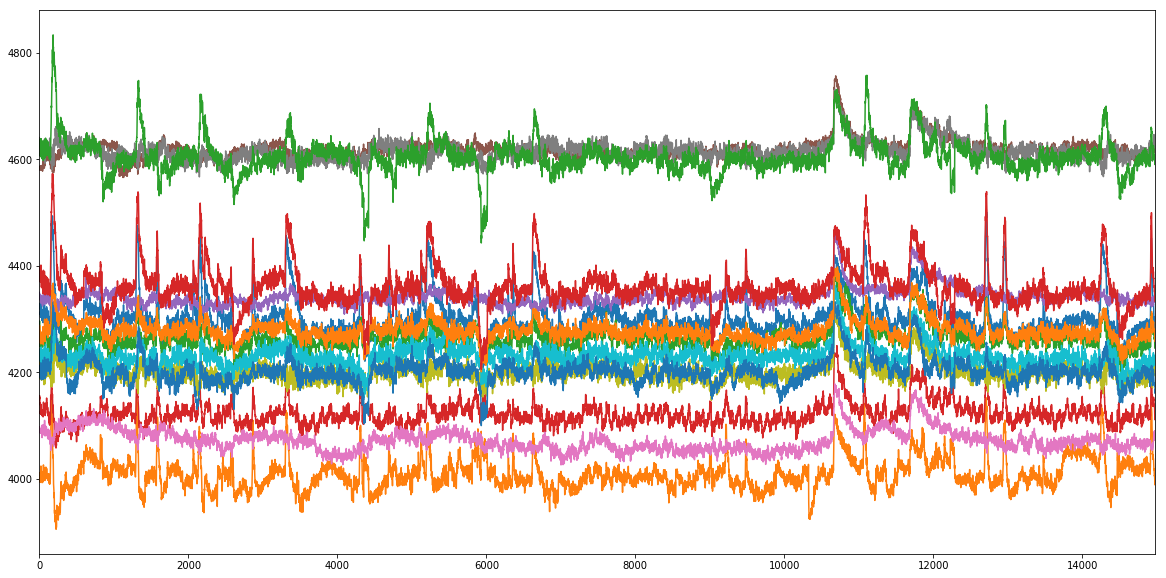

In [10]:
#replot data without outliers
df.plot(figsize=(20,10))
_ = plt.legend().remove()

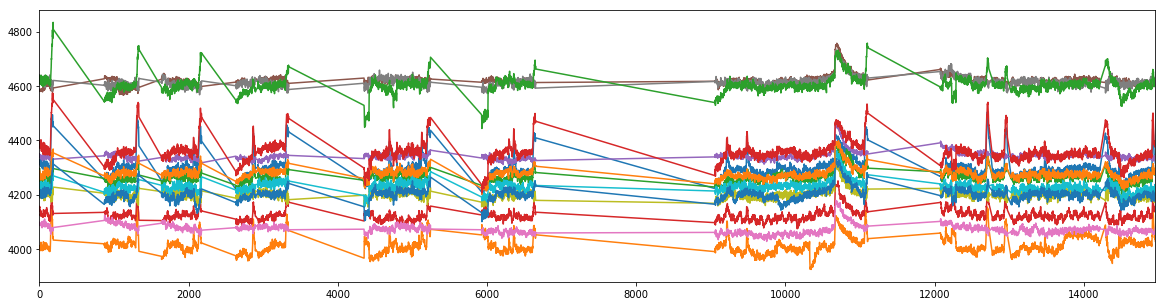

In [11]:
df[df['eyeDetection'] == '0'].plot(figsize=(20,5))
_ = plt.legend().remove()

# Train Model

Implement Classification

In [45]:
df = df.reset_index(drop=True)

In [46]:
# extract data
X = df[df.columns.difference(['eyeDetection'])]

In [49]:
X.shape

(14976, 14)

In [50]:
target.shape

(14976,)

In [47]:
# extract target
target = df['eyeDetection']

In [99]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [36]:
target = target.astype(np.int)

# Just deploy default XGboost on data (dont shuffle in the split for harder predictparts)

In [73]:
train_X, test_X, train_y, test_y = train_test_split(X, target.astype(np.int), test_size=0.3, shuffle=False)

In [100]:
model = XGBClassifier()

In [ ]:
params= []

In [95]:
model.fit(train_X, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, num_class=2, numrounds=1000,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [96]:
prediction = model.predict(test_X)

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

In [98]:
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

           0       0.82      0.46      0.59      3335
           1       0.31      0.71      0.44      1158

   micro avg       0.53      0.53      0.53      4493
   macro avg       0.57      0.59      0.51      4493
weighted avg       0.69      0.53      0.55      4493



Run a cv to get first idea of a good treesize with learning rate 0.1

In [ ]:
def CV_xg(model, dtrain, data_cols, target_cols, cv_folds=5, early_stopping_rounds=50):
    #create CV with builtin cv method of XGBoost
    xgb_param = model.get_xgb_params()
    dmat_train = xgb.DMatrix(dtrain[data_cols].values, dtrain[target].values)
    cv_result = xgb.cv(xgb_param, dmat_train, num_boost_rounds=model.get_params()['n_estimators'], nfold=cv_folds), metrics='auc', early_stopping_rounds=early_stopping_rounds)
    return cv_result